In [1]:
import pandas as pd
import numpy as np
import vegas
import sys
import os
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
import lhapdf


from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format='retina'

> # Momentum distribution:

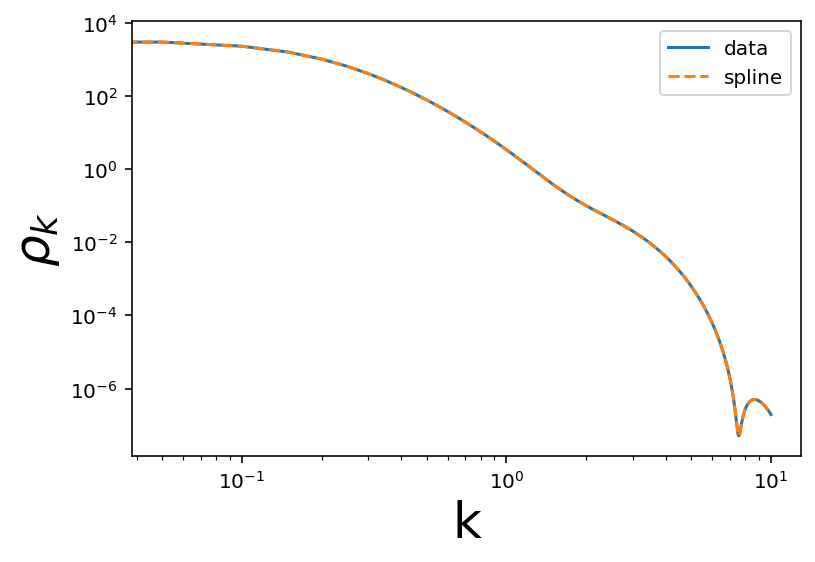

In [119]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)
"""Plot the momentum distribution."""
plt.figure(figsize=(6,4));plt.rc('axes', labelsize=25, titlesize=30);plt.plot(momentum['k'],momentum['rk'],label='data');
ps = interp1d(momentum['k'],momentum['rk'], kind='cubic');xnew = np.linspace(0, 10, 200);plt.plot(xnew, ps(xnew),'--',label='spline')
plt.xscale('log');plt.yscale('log');plt.xlabel('k');plt.ylabel(r'$\rho_k$');plt.legend();plt.show()

3.3715


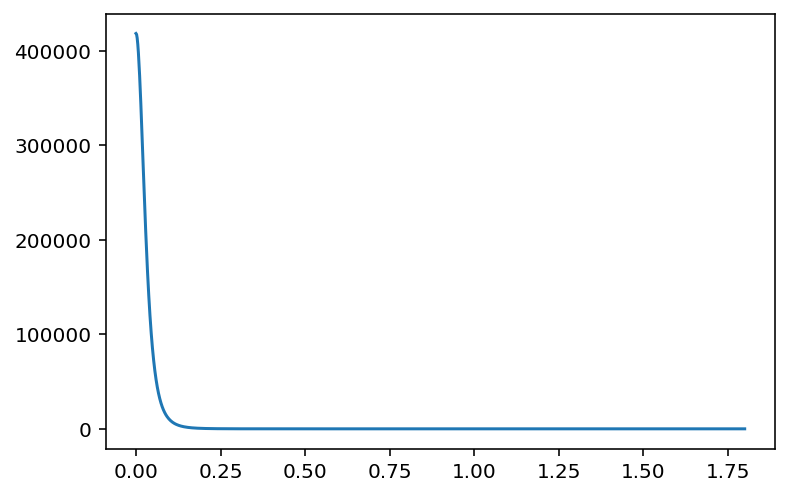

In [211]:
"""Spline object ps() now interpolates data points."""
print(ps(1))
"""We want to convert from fermi to GeV:"""
def psg(pprime):
    hbarc = 197.32*1.e-3 ; p = pprime/hbarc
    return ps(p)/hbarc**3 # answer in GeV.
p=np.linspace(0,1.8,1000)
plt.plot(p,psg(p))
#plt.yscale('log')
#plt.xscale('log')


In [4]:
"""Normalization check (dk=0.05 by default):"""
pf = (4*np.pi)/pow(2*np.pi,3) ; norm = 0 ; dk = 0.05
for ik,k in enumerate(momentum['k']):
    norm += pow(k,2)*dk*momentum['rk'][ik]
print('The normalized momentum distribution roughly equates to {n:.3f}'.format(n=norm*pf))

The normalized momentum distribution roughly equates to 1.000


In [228]:
class DIS:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.xfxQ2_vec = np.vectorize(self.__call__)

    def __call__(self, i, x, q2):
        return self.pdf.xfxQ2(i, x, q2)
    
    def F2p(self, x, q2):
        charge2 = [4/9, 1/9]
        result = 0
        for i in range(1, 6):
            result += charge2[i%2]*(self.xfxQ2_vec(i, x, q2) + self.xfxQ2_vec(-i, x, q2))
            
        return result
    def F2n(self, x, q2):
        charge2 = [1/9, 4/9]
        result = 0
        for i in range(1, 6):
            result += charge2[i%2]*(self.xfxQ2_vec(i, x, q2) + self.xfxQ2_vec(-i, x, q2))
            
        return result
    
    def F1p(self, x, q2):
        return self.F2p(x, q2)/(2*x)
    
    def F1n(self, x, q2):
        return self.F2n(x, q2)/(2*x)

In [6]:
m_p       = 0.938    # mass of proton in GeV.
m_n       = 0.939    # mass of neutron in GeV.
M_A = m_p + m_n # entire deuteron nucleus mass.

> # Vegas integration:

In [7]:
"""Testing p integral seen in t2 of _contribution()."""
def f(p):
    return p**2 * ps(p)*4*np.pi/(2*np.pi)**3
#(ps(p)/E_p(p,m_p))
integral = vegas.Integrator([[min(momentum['k']), max(momentum['k'])]])
result = integral(f, nitn=20, neval=10000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.00050(42)     1.00050(42)         0.00     1.00
  2   0.999926(61)    0.999938(61)        1.80     0.18
  3   1.000032(38)    1.000005(32)        1.77     0.17
  4   0.999969(25)    0.999983(20)        1.45     0.23
  5   0.999984(21)    0.999983(14)        1.09     0.36
  6   0.999959(19)    0.999974(11)        1.08     0.37
  7   1.000001(17)    0.9999823(96)       1.19     0.31
  8   0.999979(18)    0.9999815(84)       1.02     0.41
  9   0.999995(18)    0.9999841(76)       0.96     0.47
 10   0.999992(18)    0.9999853(70)       0.87     0.55
 11   1.000000(19)    0.9999870(66)       0.83     0.60
 12   0.999998(21)    0.9999880(63)       0.78     0.66
 13   1.000020(21)    0.9999905(60)       0.89     0.56
 14   0.999997(21)    0.9999910(58)       0.83     0.63
 15   0.999994(25)    0.9999911(56)       0.77     0.70
 16   1.000053(24)    0.9999944(55)       1.14  

In [288]:
class deut_DIS:
    def __init__(self, q2, pdf, xa_bins):
        self.xa_bins = xa_bins
        self.pdf = DIS("cteq66", 0)        
        self.q2  = q2
#        self.E   = E
    
    def qvec(self, xA):
        return np.sqrt(self.q2+self.omega(xA)**2)
    def omega(self,xA):
        return self.q2/(2*M_A*xA)
        
    def phase_space(self,p,m,flag):
        if(flag==True):
            ph_sp=2*np.pi*p**2*ps(p)/(2*np.pi)**3*m/np.sqrt(p**2+m**2)
        else:
            ph_sp= 1
        return ph_sp
        
    def xn(self,p,m,cosT,xA):
        if(p==0):
            return xA*2
        else:
            ep=np.sqrt(p**2+m**2)
            pdotq=ep*self.omega(xA)-p*cosT*self.qvec(xA)
            return self.q2/2/pdotq
        
    def f2A(self, x):
        p          = x[0]
        costh      = x[1]
        self.xa    = x[2]
        sinth = np.sqrt(1-costh**2)
        dI = np.zeros_like(self.xa_bins)
        ep=np.sqrt(p**2+m_p**2)
        pdotq=ep*self.omega(self.xa)-p*costh*self.qvec(self.xa)

        x_p=self.xn(p,m_p,costh,self.xa)
        if x_p < 0 or x_p > 1:
            return {'I':0, 'dI':dI}
        else:

            f2p=self.q2**2/self.qvec(self.xa)**4*self.pdf.F2p(x_p,self.q2)/m_p**2*(ep+(pdotq)/self.q2*self.omega(self.xa))**2
            +self.q2/self.qvec(self.xa)**2*1/2*p**2*sinth**2*self.pdf.F2p(x_p,self.q2)/m_p**2
            f2n=self.q2**2/self.qvec(self.xa)**4*self.pdf.F2n(x_p,self.q2)/m_p**2*(ep+(pdotq)/self.q2*self.omega(self.xa))**2
            +self.q2/self.qvec(self.xa)**2*1/2*p**2*sinth**2*self.pdf.F2n(x_p,self.q2)/m_p**2
                        
                           
        
            I = self.phase_space(p,m_p,True)*(f2p+f2n)
            j = np.searchsorted(self.xa_bins, self.xa)

            dI[j] = I/np.diff(self.xa_bins)[j-1]
            if np.any(dI < 0):
                print(dI)
        
        return {'I':I, 'dI':dI}
    
    def f1A(self, x):

        p          = x[0]
        costh      = x[1]
        self.xa    = x[2]
        
        
        sinth = np.sqrt(1-costh**2)
        dI = np.zeros_like(self.xa_bins)

        x_p=self.xn(p,m_p,costh,self.xa)
        if x_p < 0 or x_p > 1:
            return {'I':0, 'dI':dI}
        else:

            f1p=M_A*(self.pdf.F1p(x_p,self.q2)/m_p 
                +self.pdf.F2p(x_p,self.q2)*1/2/self.omega(self.xa)*p**2*sinth**2/m_p**2)
            f1n=M_A*(self.pdf.F1n(x_p,self.q2)/m_p 
                +self.pdf.F2n(x_p,self.q2)*1/2/self.omega(self.xa)*p**2*sinth**2/m_p**2)
        
            I = self.phase_space(p,m_p,True)*(f1p+f1n)
            #I=f1p
            j = np.searchsorted(self.xa_bins, self.xa)


            dI[j] = I/np.diff(self.xa_bins)[j-1]
            if np.any(dI < 0):
                print(dI)
        
        return {'I':I, 'dI':dI}
        
        
    
    

In [289]:
q2=3.
deut = deut_DIS(q2,pdf='cteq66',xa_bins=np.logspace(-5,0,20))

integral = vegas.Integrator([[0,0.8],[-1,1],[0,1]])

result = integral(deut.f2A, nitn=10, neval=50000)
print(result.summary())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.19394(27)     0.19394(27)         0.00     1.00
  2   0.19390(13)     9(41)               1.68     0.03
  3   0.19412(12)     19(40)              1.80     0.00
  4   0.193874(93)    29(37)              2.52     0.00
  5   0.193813(81)    17(35)              2.05     0.00
  6   0.193847(76)    13(33)              3.49     0.00
  7   0.193940(71)    -3.6(1.9)           0.78     0.97
  8   0.193762(66)    -3.6(1.7)           0.86     0.89
  9   0.193773(66)    -4.0(1.6)           0.90     0.82
 10   0.193751(60)    -0.25(82)           1.00     0.50



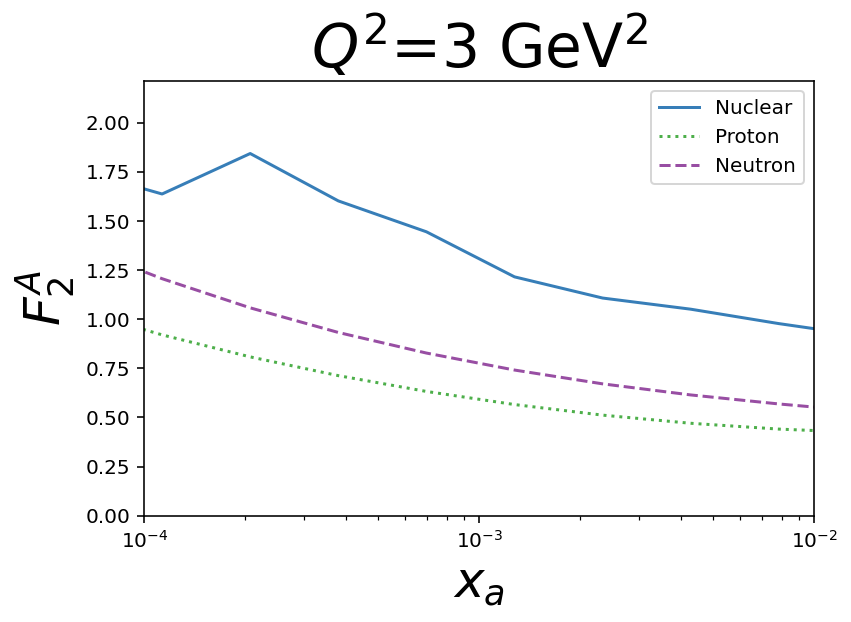

In [290]:
plt.plot(deut.xa_bins, [x.mean for x in result['dI']],color=palette(1),linestyle='-',label='Nuclear')
plt.plot(deut.xa_bins, deut.pdf.F2p(deut.xa_bins , q2),color=palette(2),linestyle=':',label='Proton')
plt.plot(deut.xa_bins, deut.pdf.F2n(deut.xa_bins , q2),color=palette(3),linestyle='--',label='Neutron')

plt.xscale('log')
#plt.yscale('log')
plt.title(r'$Q^2$=3 GeV$^2$')
plt.xlabel(r'$x_{a}$')
plt.ylabel(r'$F_{2}^{A}$')
plt.xlim(0.0001,0.01)
plt.ylim(0.,)
plt.legend(loc=1, ncol=1)
plt.savefig('f2_compare.pdf', bbox_inches='tight')

In [ ]:
q2=3.
deut = deut_DIS(q2,pdf='cteq66',xa_bins=np.logspace(-5,0,20))

integral = vegas.Integrator([[0,0.8],[-1,1],[0,1]])

#integral = vegas.Integrator([[0,1]])

result = integral(deut.f1A, nitn=10, neval=50000)
print(result.summary())

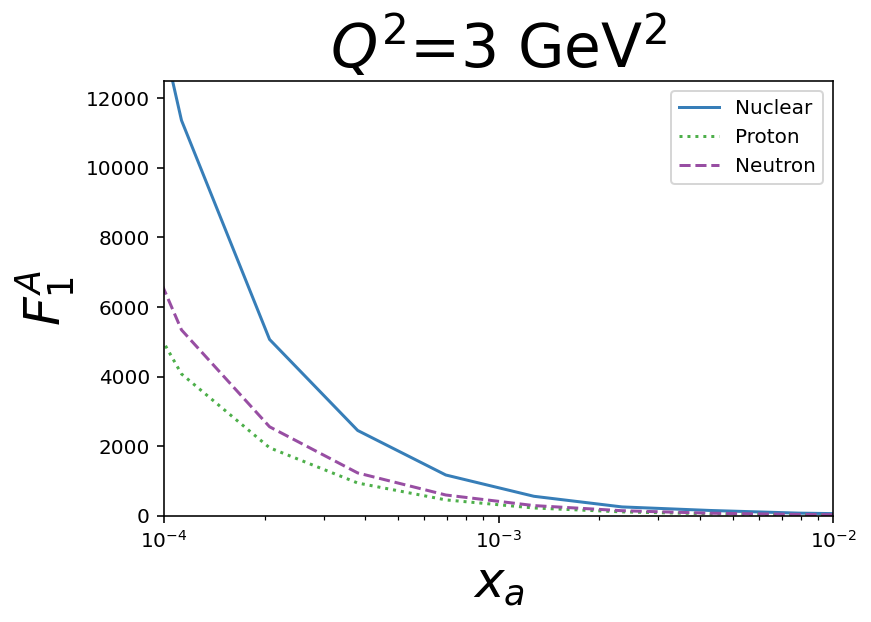

In [292]:

plt.plot(deut.xa_bins, [x.mean for x in result['dI']],color=palette(1),linestyle='-',label='Nuclear')
plt.plot(deut.xa_bins, deut.pdf.F1p(deut.xa_bins , q2),color=palette(2),linestyle=':',label='Proton')
plt.plot(deut.xa_bins, deut.pdf.F1n(deut.xa_bins , q2),color=palette(3),linestyle='--',label='Neutron')

plt.xscale('log')
#plt.yscale('log')
plt.title(r'$Q^2$=3 GeV$^2$')
plt.xlabel(r'$x_{a}$')
plt.ylabel(r'$F_{1}^{A}$')
plt.xlim(0.0001,0.01)
plt.ylim(0.,12500)
plt.legend(loc=1, ncol=1)
plt.savefig('f1_compare.pdf', bbox_inches='tight')

#plt.show()

In [ ]:
class deut_DIS_Q2:
    def __init__(self, xa, pdf, q2_bins):
        self.q2_bins = q2_bins
        self.pdf = DIS("cteq66", 0)        
        self.xa  = xa
#        self.E   = E
    
    def qvec(self, q2):
        return np.sqrt(q2+self.omega(self.xa)**2)
    def omega(self,q2):
        return q2/(2*M_A*self.xa)
        
    def phase_space(self,p,m,flag):
        if(flag==True):
            ph_sp=2*np.pi*p**2*ps(p)/(2*np.pi)**3*m/np.sqrt(p**2+m**2)
        else:
            ph_sp= 1
        return ph_sp
        
    def xn(self,p,m,cosT,q2):
        if(p==0):
            return self.xa*2
        else:
            ep=np.sqrt(p**2+m**2)
            pdotq=ep*self.omega(self.q2)-p*cosT*self.qvec(self.q2)
            return q2/2/pdotq
        
    def f2A(self, q2):
        p          = x[0]
        costh      = x[1]
        self.q2    = x[2]
        sinth = np.sqrt(1-costh**2)
        dI = np.zeros_like(self.q2_bins)
        ep=np.sqrt(p**2+m_p**2)
        pdotq=ep*self.omega(self.xa)-p*costh*self.qvec(self.xa)

        x_p=self.xn(p,m_p,costh,self.q2)
        if x_p < 0 or x_p > 1:
            return {'I':0, 'dI':dI}
        else:

            f2p=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2p(x_p,self.q2)/m_p**2*(ep+(pdotq)/self.q2*self.omega(self.q2))**2
            +self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2p(x_p,self.q2)/m_p**2
            f2n=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2n(x_p,self.q2)/m_p**2*(ep+(pdotq)/self.q2*self.omega(self.q2))**2
            +self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2n(x_p,self.q2)/m_p**2
                        
                           
        
            I = self.phase_space(p,m_p,True)*(f2p+f2n)
            j = np.searchsorted(self.q2_bins, self.q2)

            dI[j] = I/np.diff(self.q2_bins)[j-1]
            if np.any(dI < 0):
                print(dI)
        
        return {'I':I, 'dI':dI}
    
    def f1A(self, x):

        p          = x[0]
        costh      = x[1]
        self.q2    = x[2]
        
        
        sinth = np.sqrt(1-costh**2)
        dI = np.zeros_like(self.q2_bins)

        x_p=self.xn(p,m_p,costh,self.q2)
        if x_p < 0 or x_p > 1:
            return {'I':0, 'dI':dI}
        else:

            f1p=M_A*(self.pdf.F1p(x_p,self.q2)/m_p 
                +self.pdf.F2p(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
            f1n=M_A*(self.pdf.F1n(x_p,self.q2)/m_p 
                +self.pdf.F2n(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
        
            I = self.phase_space(p,m_p,True)*(f1p+f1n)
            #I=f1p
            j = np.searchsorted(self.q2_bins, self.q2)


            dI[j] = I/np.diff(self.q2_bins)[j-1]
            if np.any(dI < 0):
                print(dI)
        
        return {'I':I, 'dI':dI}
        
        
    
    